In [77]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [78]:
data_in = pd.read_csv('rolling_forecast_predictions.csv')
data_in.head()

,Date,AAPL,ADBE,AMD,AVGO,CRM,MSFT,NVDA
0,2023-10-25,0.000424,0.000224,0.002180,0.002258,0.000952,0.000686,-0.001371
1,2023-10-26,0.000785,-0.001906,-0.001963,0.002422,-0.000865,-0.000728,-0.002004
2,2023-10-27,0.000368,-0.001065,0.002292,0.001173,0.002193,-0.002137,0.001902
3,2023-10-30,0.001483,-0.001038,0.002554,0.002382,0.001159,0.002236,0.006129
4,2023-10-31,0.000956,0.002234,0.001307,0.004203,0.002623,0.001861,0.005998


In [79]:
# data needs to be inputted
data_in = pd.read_csv('rolling_forecast_predictions.csv').drop(columns=['Date'])
print(f"read {data_in.shape[0]} rows")
risky_assets = ['MSFT', 'AAPL', 'NVDA', 'AVGO', 'CRM', 'AMD', 'ADBE']
data_in.head()

read 151 rows


,AAPL,ADBE,AMD,AVGO,CRM,MSFT,NVDA
0,0.000424,0.000224,0.002180,0.002258,0.000952,0.000686,-0.001371
1,0.000785,-0.001906,-0.001963,0.002422,-0.000865,-0.000728,-0.002004
2,0.000368,-0.001065,0.002292,0.001173,0.002193,-0.002137,0.001902
3,0.001483,-0.001038,0.002554,0.002382,0.001159,0.002236,0.006129
4,0.000956,0.002234,0.001307,0.004203,0.002623,0.001861,0.005998


In [80]:
# data parameters
n_monto_carlo = 10 ** 7
start_date = '2023-10-25'
end_date = '2024-05-31'
n_assets = len(risky_assets)
N_DAYS = data_in.shape[0]

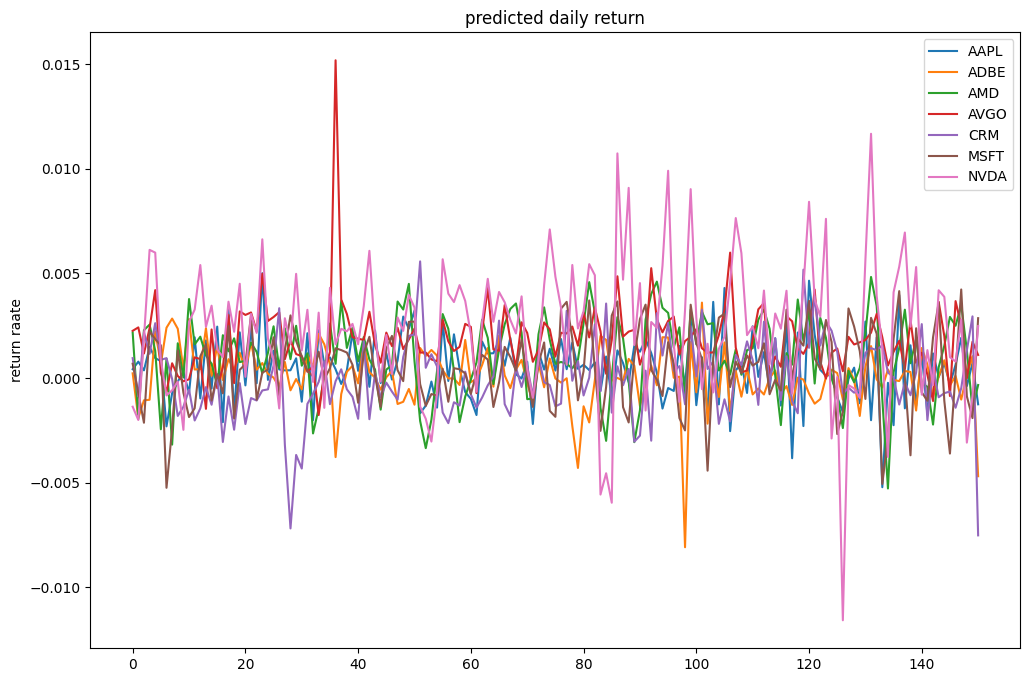

In [81]:
# choose Adj Close
data_in.plot(title='predicted daily return')
plt.ylabel('return raate')
plt.show()

# 平均回报率和协方差矩阵

In [82]:
avg_returns = data_in.mean() * N_DAYS
cov_mat = data_in.cov() * N_DAYS
avg_returns, cov_mat

(AAPL    0.069934
 ADBE    0.011080
 AMD     0.162770
 AVGO    0.276772
 CRM    -0.009795
 MSFT    0.075050
 NVDA    0.349201
 dtype: float64,
           AAPL      ADBE       AMD      AVGO       CRM      MSFT      NVDA
 AAPL  0.000395  0.000037  0.000100  0.000061  0.000041  0.000176  0.000198
 ADBE  0.000037  0.000298  0.000002 -0.000084  0.000090 -0.000020 -0.000017
 AMD   0.000100  0.000002  0.000527  0.000091  0.000026  0.000150  0.000433
 AVGO  0.000061 -0.000084  0.000091  0.000434  0.000004  0.000105  0.000192
 CRM   0.000041  0.000090  0.000026  0.000004  0.000543 -0.000028  0.000023
 MSFT  0.000176 -0.000020  0.000150  0.000105 -0.000028  0.000531  0.000282
 NVDA  0.000198 -0.000017  0.000433  0.000192  0.000023  0.000282  0.001551)

In [83]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [84]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [85]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [86]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

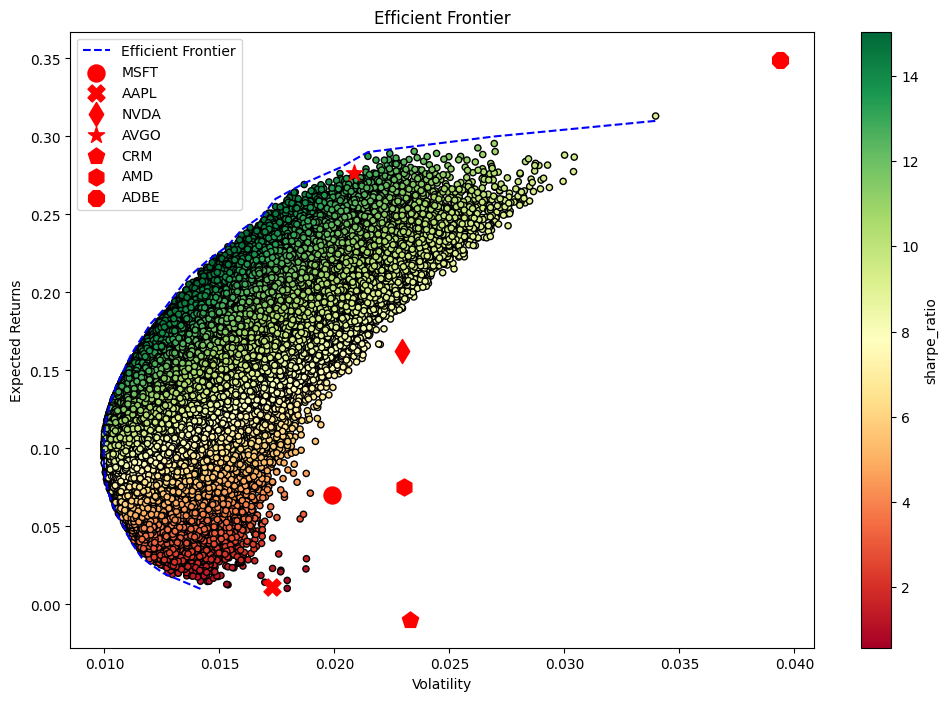

In [87]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_assets[asset_index])
ax.legend()
plt.show()

In [88]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [89]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 21.37% volatility: 1.42% sharpe_ratio: 1504.02% 
Weights:
MSFT: 0.36% AAPL: 18.92% NVDA: 10.48% AVGO: 56.12% CRM: 1.73% AMD: 1.52% ADBE: 10.87% 

In [90]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 9.44% volatility: 1.00% sharpe_ratio: 946.09% 
Weights:
MSFT: 13.73% AAPL: 34.06% NVDA: 7.19% AVGO: 22.20% CRM: 11.82% AMD: 10.73% ADBE: 0.28% 

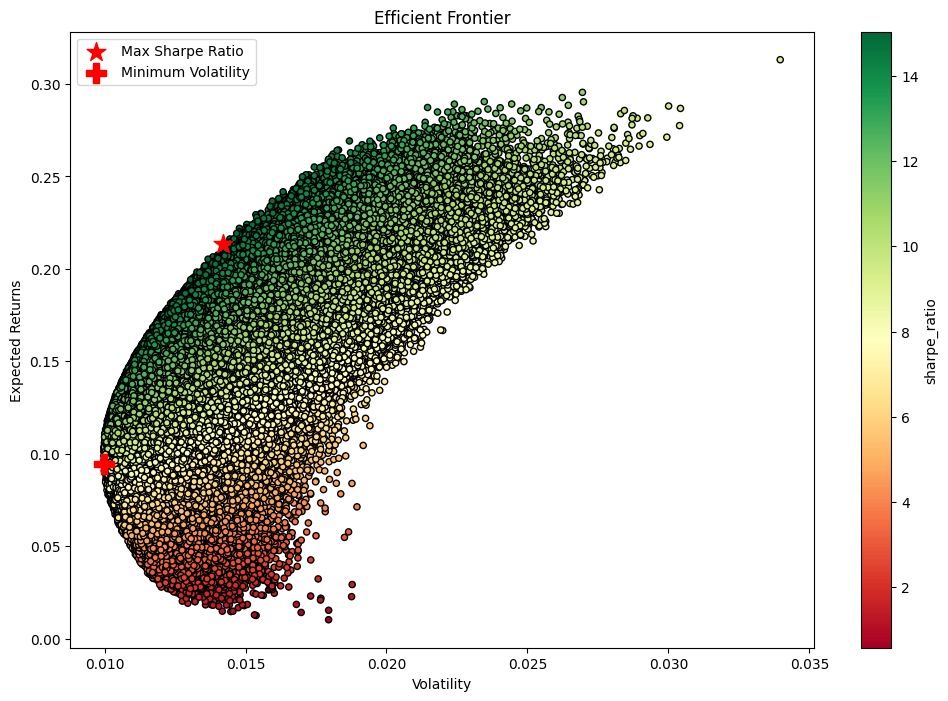

In [91]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()